In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import csv
from numpy import genfromtxt
from scipy.spatial import distance
import os
import glob
from pylab import *
from matplotlib.pyplot import imread
import networkx as nx

In [2]:
# display more when printing
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

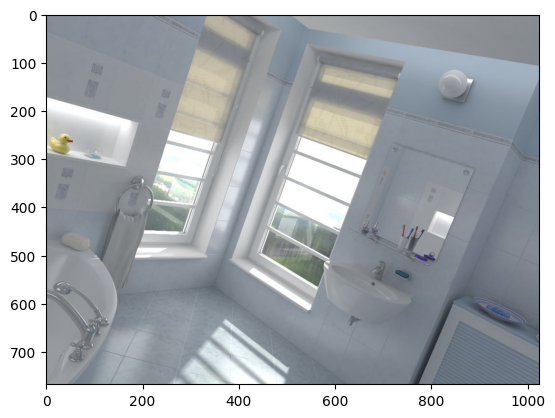

In [3]:
frame_no = 0

# import sample tonemap
sample_tonemap_image = imread(r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\images\scene_cam_00_final_preview\frame.0000.tonemap.jpg")

# import semantic segmentation of sample image
semantic_inst_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\images\scene_cam_00_geometry_hdf5\frame.0000.semantic_instance.hdf5"
with h5py.File(semantic_inst_path, "r") as f: semantic_inst = f['dataset'][:]

plt.imshow(sample_tonemap_image)
# plt.imshow(semantic_inst)

# import camera positions + orientations files
camera_positions_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\cam_00\camera_keyframe_positions.hdf5"
camera_orientations_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\cam_00\camera_keyframe_orientations.hdf5"

# import bb information
bb_size_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\mesh\metadata_semantic_instance_bounding_box_object_aligned_2d_extents.hdf5"
bb_orientation_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\mesh\metadata_semantic_instance_bounding_box_object_aligned_2d_orientations.hdf5"
bb_position_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\mesh\metadata_semantic_instance_bounding_box_object_aligned_2d_positions.hdf5"
# bb_names = ...

# import bb label information (will be grouped under bb_names)
mesh_objects_si_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\evermotion_dataset\scenes\ai_001_001\_detail\mesh\mesh_objects_si.hdf5"
mesh_objects_sii_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\evermotion_dataset\scenes\ai_001_001\_detail\mesh\mesh_objects_sii.hdf5"
metadata_objects_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\evermotion_dataset\scenes\ai_001_001\_detail\mesh\metadata_objects.csv"
nyu_labels_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\code\cpp\tools\scene_annotation_tool\semantic_label_descs.csv"

with h5py.File(camera_positions_path, "r") as f: camera_positions = f['dataset'][:]
with h5py.File(camera_orientations_path, "r") as f: camera_orientations = f['dataset'][:]

with h5py.File(bb_size_path, "r") as f: bb_sizes = f['dataset'][:]
with h5py.File(bb_orientation_path, "r") as f: bb_orientations = f['dataset'][:]
with h5py.File(bb_position_path, "r") as f: bb_positions = f['dataset'][:]

with h5py.File(mesh_objects_si_path, "r") as f: mesh_objects_si = f['dataset'][:]
with h5py.File(mesh_objects_sii_path, "r") as f: mesh_objects_sii = f['dataset'][:]
metadata_objects = genfromtxt(metadata_objects_path, delimiter=None, dtype=str)
nyu_labels = genfromtxt(nyu_labels_path, delimiter=',', dtype=None, encoding=None, autostrip=True)

# import asset to meters unit conversion
with open(r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\metadata_scene.csv", newline='') as csvfile:
    metadata_scene = list(csv.reader(csvfile))
    a2m = float(metadata_scene[1][1])

In [4]:
sample_camera_orientation = camera_orientations[frame_no]
sample_camera_position = camera_positions[frame_no]

R_world_from_cam = matrix(sample_camera_orientation)
t_world_from_cam = matrix(sample_camera_position).T
R_cam_from_world = R_world_from_cam.T
t_cam_from_world = -R_cam_from_world*t_world_from_cam

height_pixels = sample_tonemap_image.shape[0] 
width_pixels  = sample_tonemap_image.shape[1]

fov_x = pi/3.0
fov_y = 2.0 * arctan(height_pixels * tan(fov_x/2.0) / width_pixels)
near = 1.0
far = 1000.0

f_h    = tan(fov_y/2.0)*near # focal length in h??
f_w    = f_h*width_pixels/height_pixels
left   = -f_w
right  = f_w
bottom = -f_h
top    = f_h

# Construct M (projection matrix mapping from camera view to clip view)
M_proj      = matrix(zeros((4,4)))
M_proj[0,0] = (2.0*near)/(right - left)
M_proj[1,1] = (2.0*near)/(top - bottom)
M_proj[0,2] = (right + left)/(right - left)
M_proj[1,2] = (top + bottom)/(top - bottom)
M_proj[2,2] = -(far + near)/(far - near)
M_proj[3,2] = -1.0
M_proj[2,3] = -(2.0*far*near)/(far - near)

# Construct world to screen matrix
def transform_point_screen_from_world(p_world):
    # projection matrix for: from P_world to P_cam
    p_cam      = t_cam_from_world + R_cam_from_world*p_world
    p_cam_     = matrix(r_[ p_cam.A1, 1 ]).T
    p_clip     = M_proj*p_cam_
    # projection matrix for: from P_world to P_ndc
    p_ndc      = p_clip/p_clip[3]
    p_ndc_     = p_ndc.A1
    p_screen_x = 0.5*(p_ndc_[0]+1)*(width_pixels-1)
    p_screen_y = (1 - 0.5*(p_ndc_[1]+1))*(height_pixels-1)
    p_screen_z = (p_ndc_[2]+1)/2.0 # why is there a z-component in screen coords?
    p_screen   = matrix([p_screen_x, p_screen_y, p_screen_z]).T
    return p_screen

In [5]:
bb_in_sample = unique(semantic_inst)
if bb_in_sample[0] == -1:
    bb_in_sample = bb_in_sample[1:]

n_bb_in_sample = bb_in_sample.shape[0]
print(n_bb_in_sample)

# bb_in_sample_mask = np.zeros((n_bb, n_bb), dtype=int)
# for bb_id in bb_in_sample:
#     bb_in_sample_mask[bb_id, bb_id] = 1

32


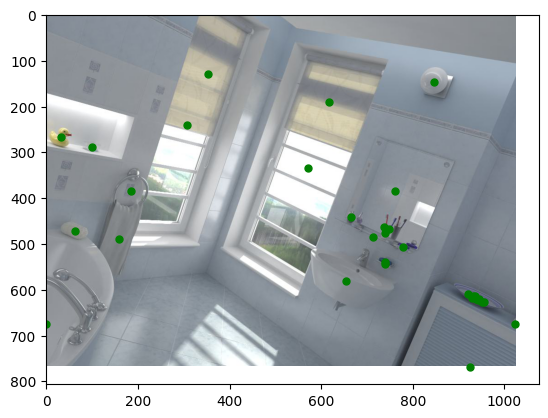

In [6]:
plt.imshow(sample_tonemap_image)
x=[]
y=[]
for i in bb_in_sample:
    centre = transform_point_screen_from_world(expand_dims(bb_positions[i], 1))
    xi = np.clip(centre[0].item(), 0, width_pixels)
    yi = np.clip(centre[1].item(), 0, height_pixels)
    x.append(xi)
    y.append(yi)
plt.plot(x, y, "og", markersize=5)
# for i, bb in enumerate(bb_in_sample):
#     plt.text(x[i], y[i], bb_labels[bb-1], fontsize=8)

In [21]:
for i in range(bb_positions.shape[0]-1):
    bb_i_instances = np.where(mesh_objects_sii == i+1)
    lowlvl_label = metadata_objects[bb_i_instances[0]]
    # print(bb_i_instances[0]) # eg. low-level objects 170 and 683 belong to BB1
    print(lowlvl_label)


['floor_tile_obj_152' 'small_shelf_obj_']
['shampoo1_obj_04' 'shampoo2_obj_01' 'shampoo2_obj_02' 'shampoo2_obj_03']
['perfume3_obj_06' 'nail_polish_obj_02']
['window2_obj_12']
['cotton_bud_obj_03' 'cotton_bud_obj_04']
['towel1_obj_01']
['lavatory_paper_obj_03']
['roller2_blind_obj_01' 'roller2_blind_obj_02']
['window1_obj_12' 'window2_obj_02' 'window2_obj_03' 'window2_obj_04'
 'window2_obj_05' 'window2_obj_06' 'window2_obj_09' 'window2_obj_10']
['roller1_blind_obj_01' 'roller1_blind_obj_02']
['heater_obj_23' 'window1_obj_01' 'window1_obj_02' 'window1_obj_03'
 'window1_obj_04' 'window1_obj_05' 'window1_obj_06' 'window1_obj_09'
 'window1_obj_10']
['lamp_obj_10' 'lamp_obj_03']
['decoration1_obj_09' 'perfume3_obj_01']
['toothbrush_obj_01']
['toothbrush_obj_04' 'toothbrush_obj_02']
['shampoo2_obj_04' 'toothbrush_obj_03']
['tray' 'nivea_obj_01']
['perfume3_obj_03']
['duck_obj_03' 'mirror_obj_01' 'mirror_obj_02' 'mirror_obj_03'
 'mirror_obj_04']
['tape']
['soap_box_obj_01' 'soap_box_obj_02' '

In [37]:
bb_labels = []
n_bb = bb_positions.shape[0] - 1 # 1st element of bb_positions is inf
id_i = np.zeros(n_bb)

for i in range(n_bb):
    instances = np.where(mesh_objects_sii == i+1)[0] # low-level objects belonging to BB i+1
    id_i[i] = mesh_objects_si[instances[0]] # all low-level objects belonging to same BB should have the same label, so just take the 1st one
    
    nyu_id = []
    for j in range(len(instances)):
        nyu_id.append(mesh_objects_si[instances[j]])
    # print('!', np.unique(nyu_id).shape[0])
    if np.unique(nyu_id).shape[0] != 1:
        print('nyu_id clash')

    if id_i[i] == 40 or id_i[i] == 39 or id_i[i] == 38:
        bb_labels.append(metadata_objects[instances[-1]]) # assign low-level object name to the bounding box when there is no NYU label available
        # print(np.where(mesh_objects_sii == i+1)[0])
        # print(f"-> possible choices: {metadata_objects[instances]}, assigned low-lvl name {metadata_objects[instances[-1]]}")
    else:
        bb_labels.append(nyu_labels[int(id_i[i])][1]) # assign (more general) NYU label rather than low-level object label
        # print(f"-> assigned {nyu_labels[int(id_i[i])][1]} instead of {metadata_objects[instances[0]]}")

print(f"Number of BBs: {len(bb_labels)} \n")
print(f"BB labels: {bb_labels}") # labels for each BB

Number of BBs: 55 

BB labels: ['small_shelf_obj_', 'shampoo2_obj_03', 'nail_polish_obj_02', 'window2_obj_12', 'cotton_bud_obj_04', 'towel', 'lavatory_paper_obj_03', 'blinds', 'window', 'blinds', 'window', 'lamp', 'perfume3_obj_01', 'toothbrush_obj_01', 'toothbrush_obj_02', 'toothbrush_obj_03', 'nivea_obj_01', 'shelves', 'mirror', 'tape', 'soap_box_obj_03', 'sink', 'cabinet', 'decoration1_obj_08', 'decoration1_obj_07', 'decoration1_obj_02', 'decoration1_obj_06', 'decoration1_obj_01', 'wall_tile_obj_330', 'decoration1_obj_04', 'decoration1_obj_05', 'decoration1_obj_03', 'towel', 'towel', 'toilet', 'bath_tub_obj_03', 'lavatory_paper_obj_01', 'lavatory_paper_obj_02', 'lamp', 'wall_cupboard_obj_05', 'wall_cupboard_obj_04', 'heater_obj_22', 'door', 'towel', 'towel', 'perfume3_obj_04', 'shampoo1_obj_02', 'brush_obj_01', 'lamp', 'towel2_obj_01', 'towel', 'bathtub', 'cabinet', 'sponge_01', 'lamp']
